In [1]:
#!pip3 install bayesian-optimization==0.6 --user

  Created wheel for bayesian-optimization: filename=bayesian_optimization-0.6.0-py3-none-any.whl size=10831 sha256=9aa60cd450f4a9b2f545b37ace73fad9fd246519fae411ab993725bca3b6a415
  Stored in directory: c:\users\test\appdata\local\pip\cache\wheels\72\88\a6\b649cdcbd90b7674f43d2e14ed9ce0b4297cf7da766370f821
Successfully built bayesian-optimization


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

pandas==1.2.3
seaborn==0.10.1
numpy==1.16.6
matplotlib==3.2.2


In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [5]:
from datetime import date
import nsepy as nse
import datetime as dt


data = nse.get_history(symbol='HDFC', start=dt.date(2016,1,1), end=date.today())
df = pd.DataFrame(data)

In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 31, 'skip': 2, 'population_size': 12, 'sigma': 0.5414295804251205, 'learning_rate': 0.28477013961230563, 'size_network': 616}
time taken to train: 33.05278038978577 seconds
stop after 100 iteration with investment 507.367000
    1 | 00m33s |  507.36700 |          0.2848 |           12.4489 |    0.5414 |       615.5254 |    2.2533 |       30.7069 | 

Search parameters {'window_size': 47, 'skip': 15, 'population_size': 36, 'sigma': 0.32907976067803524, 'learning_rate': 0.25532256291235605, 'size_network': 303}
time taken to train: 14.92147707939148 seconds
stop after 100 iteration with investment 400.073000
    2 | 00m14s |  400.07300 |          0.2553 |           36.2290 |    0.3291 |       

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
    9 | 00m01s |    0.00000 |          0.2723 |            2.4533 |    0.1866 |       514.5405 |    6.7499 |       24.5411 | 

Search parameters {'window_size': 5, 'skip': 10, 'population_size': 43, 'sigma': 0.5782603335021574, 'learning_rate': 0.32886024469424463, 'size_network': 195}
time taken to train: 11.394707918167114 seconds
stop after 100 iteration with investment 239.890000
   10 | 00m11s |  239.89000 |          0.3289 |           43.2759 |    0.5783 |       195.0365 |   10.0686 |        5.4453 | 

Search parameters {'window_size': 30, 'skip': 15, 'population_size': 44, 'sigma': 0.7461044372802907, 'learning_rate': 0.48782283424479045, 'size_network': 693}
time taken to train: 24.449751377105713 seconds
stop after 100 iteration with investment 355.962000
   11 | 00m24s |  355.96200 |          0.4878 |           43.8236 |    0.7461 |       693.4430 |   14.7047 |       30.2139 | 

Search parameters {'window_size': 23, 'skip': 2,

time taken to train: 212.43125247955322 seconds
stop after 100 iteration with investment 328.407000
   31 | 04m47s |  328.40700 |          0.2200 |           25.2560 |    0.7920 |       701.5437 |    1.0120 |       37.5370 | 

Search parameters {'window_size': 16, 'skip': 3, 'population_size': 47, 'sigma': 0.8029230460466278, 'learning_rate': 0.04685504591330488, 'size_network': 71}
time taken to train: 42.57544994354248 seconds
stop after 100 iteration with investment 109.562500
   32 | 00m43s |  109.56250 |          0.0469 |           46.5128 |    0.8029 |        70.5831 |    3.3938 |       16.2791 | 

Search parameters {'window_size': 14, 'skip': 4, 'population_size': 5, 'sigma': 0.23769193325743745, 'learning_rate': 0.2734623688818956, 'size_network': 155}
time taken to train: 3.737401008605957 seconds
stop after 100 iteration with investment 277.283500
   33 | 00m16s |  277.28350 |          0.2735 |            4.7648 |    0.2377 |       155.3343 |    3.8316 |       13.8420 | 

Sea

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   42 | 00m09s |    0.00000 |          0.4437 |           10.5153 |    0.0815 |       971.8211 |    4.7412 |       13.4122 | 

Search parameters {'window_size': 17, 'skip': 9, 'population_size': 19, 'sigma': 0.9168490519653583, 'learning_rate': 0.41407705074626877, 'size_network': 855}
time taken to train: 12.905998706817627 seconds
stop after 100 iteration with investment 296.558500
   43 | 00m14s |  296.55850 |          0.4141 |           18.7097 |    0.9168 |       854.6200 |    8.8231 |       16.7210 | 

Search parameters {'window_size': 24, 'skip': 12, 'population_size': 8, 'sigma': 0.39075489137180486, 'learning_rate': 0.46744471708623186, 'size_network': 233}
time taken to train: 2.9005818367004395 seconds
stop after 100 iteration with investment 390.503000
   44 | 00m04s |  390.50300 |          0.4674 |            8.3866 |    0.3908 |       232.6001 |   11.9273 |       24.3108 | 

Search parameters {'window_size': 33, 'skip': 2,

<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   53 | 00m03s |    0.00000 |          0.3481 |           11.8315 |    0.0390 |       670.4569 |    8.1116 |       37.9707 | 

Search parameters {'window_size': 39, 'skip': 14, 'population_size': 40, 'sigma': 0.022064443744617374, 'learning_rate': 0.2363215648111258, 'size_network': 85}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   54 | 00m03s |    0.00000 |          0.2363 |           39.7580 |    0.0221 |        84.8973 |   13.9918 |       38.8545 | 

Search parameters {'window_size': 8, 'skip': 12, 'population_size': 46, 'sigma': 0.3499034927991804, 'learning_rate': 0.41056591497138617, 'size_network': 655}
time taken to train: 18.23546314239502 seconds
stop after 100 iteration with investment 379.905000
   55 | 00m20s |  379.90500 |          0.4106 |           45.7783 |    0.3499 |       654.7259 |   12.3727 |        8.1654 | 

Search parameters {'window_size': 10, 'skip': 11, 'population_size': 12, 'sigma': 0.11761202564459401, 'learning_rate': 0.392434261513917, 'size_network': 534}


<ipython-input-7-4efaf2b7209b>:39: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
   56 | 00m06s |    0.00000 |          0.3924 |           12.2822 |    0.1176 |       534.1246 |   11.3463 |        9.9885 | 

Search parameters {'window_size': 38, 'skip': 13, 'population_size': 16, 'sigma': 0.2220046880759994, 'learning_rate': 0.16049274869506086, 'size_network': 526}
time taken to train: 10.297220230102539 seconds
stop after 100 iteration with investment 373.725500
   57 | 00m12s |  373.72550 |          0.1605 |           15.6231 |    0.2220 |       525.6202 |   13.1741 |       38.2618 | 

Search parameters {'window_size': 39, 'skip': 15, 'population_size': 32, 'sigma': 0.6551917033449263, 'learning_rate': 0.4075614443643631, 'size_network': 129}
time taken to train: 10.926066398620605 seconds
stop after 100 iteration with investment 319.720500
   58 | 00m13s |  319.72050 |          0.4076 |           32.0608 |    0.6552 |       129.2103 |   14.5224 |       38.9956 | 

Search parameters {'window_size': 8, 'skip': 2, 


Search parameters {'window_size': 3, 'skip': 9, 'population_size': 38, 'sigma': 0.5394701149972481, 'learning_rate': 0.2629786068284044, 'size_network': 27}
time taken to train: 8.340720176696777 seconds
stop after 100 iteration with investment 197.712500
   78 | 00m10s |  197.71250 |          0.2630 |           37.8896 |    0.5395 |        27.0096 |    9.3467 |        3.2972 | 

Search parameters {'window_size': 33, 'skip': 5, 'population_size': 22, 'sigma': 0.18143393118669746, 'learning_rate': 0.04409713948814967, 'size_network': 176}
time taken to train: 19.935460567474365 seconds
stop after 100 iteration with investment 390.535500
   79 | 00m22s |  390.53550 |          0.0441 |           22.2365 |    0.1814 |       175.5925 |    4.6172 |       32.8204 | 

Search parameters {'window_size': 12, 'skip': 13, 'population_size': 19, 'sigma': 0.5336026289661475, 'learning_rate': 0.3909356898309288, 'size_network': 655}
time taken to train: 7.584872484207153 seconds
stop after 100 iterat

In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 783.388000
Best AGENT parameters:  {'window_size': 34.720944908770605, 'skip': 1.1533679955600171, 'population_size': 28.65383525025448, 'sigma': 0.25255104741329215, 'learning_rate': 0.30076853627199646, 'size_network': 704.7330401085627}


#### My selected parameters

In [13]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 89.8796820640564 seconds


590.0630000000001

#### bayesian parameters

In [14]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 214.93958830833435 seconds


685.0384999999999

#### My selected parameters

iter 100. reward: 626.596000
iter 200. reward: 669.887000
iter 300. reward: 744.531000
iter 400. reward: 797.918500
iter 500. reward: 893.679500
time taken to train: 488.53988337516785 seconds
day 6: buy 5 units at price 5807.750000, total balance 4192.250000
day 8, sell 5 units at price 5838.250000, investment 0.525160 %, total balance 10030.500000,
day 11: buy 5 units at price 5659.000000, total balance 4371.500000
day 12, sell 5 units at price 5765.000000, investment 1.873122 %, total balance 10136.500000,
day 13: buy 1 units at price 1136.650000, total balance 8999.850000
day 14: buy 5 units at price 5655.500000, total balance 3344.350000
day 16: buy 1 units at price 1174.600000, total balance 2169.750000
day 17, sell 5 units at price 5849.750000, investment 414.648309 %, total balance 8019.500000,
day 18, sell 2 units at price 2295.500000, investment -59.411193 %, total balance 10315.000000,
day 19: buy 5 units at price 5900.000000, total balance 4415.000000
day 20: buy 5 units at

day 840: buy 5 units at price 10739.250000, total balance 30906.450000
day 842: buy 5 units at price 10922.000000, total balance 19984.450000
day 843, sell 5 units at price 10913.250000, investment 410.251075 %, total balance 30897.700000,
day 844, sell 5 units at price 11152.250000, investment 3.845706 %, total balance 42049.950000,
day 845: buy 5 units at price 11119.750000, total balance 30930.200000
day 848: buy 5 units at price 10970.250000, total balance 19959.950000
day 849, sell 5 units at price 10949.250000, investment 0.249496 %, total balance 30909.200000,
day 850, sell 5 units at price 10909.750000, investment -1.888532 %, total balance 41818.950000,
day 853: buy 5 units at price 10865.000000, total balance 30953.950000
day 854: buy 5 units at price 10765.000000, total balance 20188.950000
day 858: buy 5 units at price 10744.500000, total balance 9444.450000
day 859: buy 5 units at price 10864.000000, total balance -1419.550000
day 864, sell 5 units at price 11406.250000, i

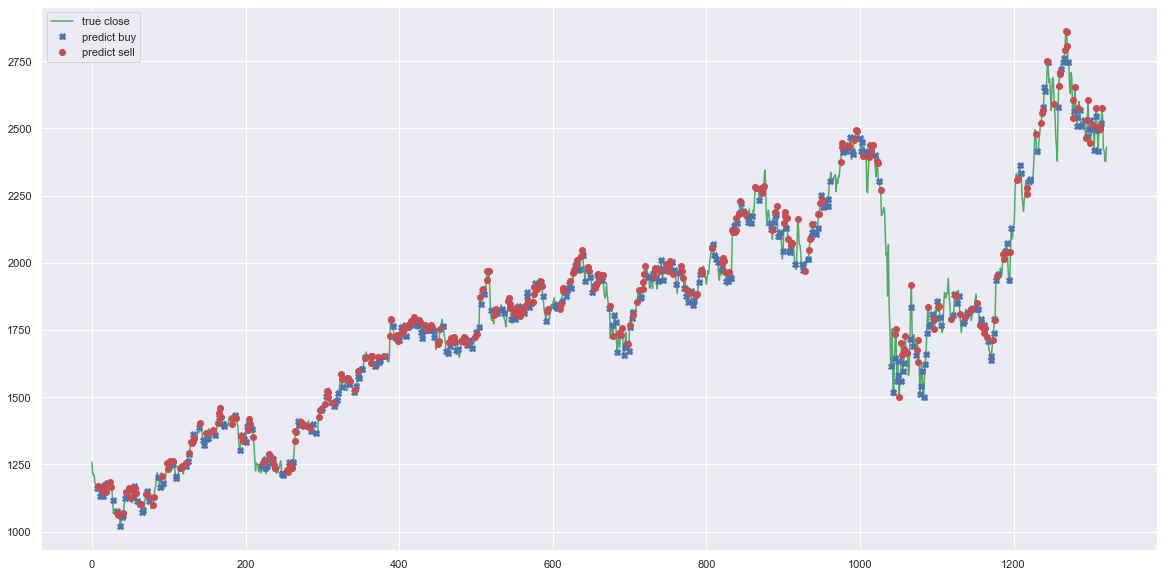

In [15]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

In [ ]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()

iter 100. reward: 750.976500
iter 200. reward: 838.719000
iter 300. reward: 928.369000
iter 400. reward: 992.299000
